# Section 1 - Load apps

In [1]:
# Initial imports and setup
import datetime as dt
import sys
import warnings
import os
import numpy as np
import pandas as pd
import xarray as xr
import datacube
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import odc.geo.xr
from ipyleaflet import GeoData
from time import time as time
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from matplotlib import colormaps
from matplotlib.patches import Patch

from IPython.display import display
from ipywidgets import widgets

warnings.filterwarnings("ignore")

# Setup paths and Datacube instance
current_dir = os.getcwd()
tools_path = os.path.join(current_dir, "Tools")
working_path = os.path.join(current_dir, "Working")

sys.path.insert(1, tools_path)
sys.path.insert(1, working_path)
dc = datacube.Datacube()

# Ensure openpyxl and tqdm are installed
!pip install openpyxl tqdm

time_range = None

# Function to import display_tools.py if exists
def import_display_tools(path):
    if os.path.exists(path) and "display_tools.py" in os.listdir(path):
        try:
            from display_tools import display_da
            print(f"display_tools module imported successfully from {path}.")
        except ImportError as e:
            print(f"Error importing display_tools from {path}: {e}")
    else:
        print(f"display_tools.py not found in {path}.")

# Function to import landcover.py if exists
def import_landcover(path):
    if os.path.exists(path) and "landcover.py" in os.listdir(path):
        try:
            from landcover import lc_colourmap, make_colorbar, plot_land_cover
            print(f"landcover module imported successfully from {path}.")
        except ImportError as e:
            print(f"Error importing landcover from {path}: {e}")
    else:
        print(f"landcover.py not found in {path}.")

# Import modules
import_display_tools(tools_path)
import_display_tools(working_path)
import_landcover(working_path)

# List files in Tools and Working
def list_files(path):
    if os.path.exists(path):
        print(f"Files in {path}:")
        print(os.listdir(path))
    else:
        print(f"{path} does not exist.")

list_files(tools_path)
list_files(working_path)

print("Section 1: Initial imports and setup - Completed")

# Manually invoke garbage collection without printing the result
import gc
import contextlib
with contextlib.redirect_stdout(None):
    gc.collect()

# Additional imports and setup
from odc.algo import xr_reproject
from dea_tools.plotting import rgb, display_map
from dea_tools.datahandling import wofs_fuser
from dea_tools.plotting import plot_wo
from matplotlib import colors as mcolours
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils import masking
from datacube.utils.masking import mask_invalid_data
from datacube.utils.cog import write_cog
from odc.geo.geom import Geometry

# For DEA burn mapping
from datetime import datetime, timedelta

from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)


display_tools.py not found in /home/jovyan/Living_Coasts_training/Tools.
display_tools.py not found in /home/jovyan/Living_Coasts_training/Working.
landcover.py not found in /home/jovyan/Living_Coasts_training/Working.
/home/jovyan/Living_Coasts_training/Tools does not exist.
/home/jovyan/Living_Coasts_training/Working does not exist.
Section 1: Initial imports and setup - Completed


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/8787/status,
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37779,Workers: 1
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:39419,Total threads: 2
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/41191/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:45541,


2024-07-25 11:01:30,154 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:39419' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('dc_load_bare_gradation-1ed2b03cf85f4f18ab9e8e011cdffaa5', 7, 0, 0), ('dc_load_full_classification-3521fb35c7c54579a6a4c99680ea1f4f', 4, 0, 0), ('dc_load_full_classification-3521fb35c7c54579a6a4c99680ea1f4f', 6, 0, 0), ('dc_load_water_state-660bf084e6af4e6ba67f6a9390244117', 4, 0, 0), ('dc_load_intertidal-e7918069758048cf8f73e31e67ff54a6', 4, 0, 0), ('dc_load_full_classification-3521fb35c7c54579a6a4c99680ea1f4f', 3, 0, 0), ('dc_load_vegetation_cover-1e52090da1a640f1b383e03a21977eaa', 2, 0, 0), ('dc_load_full_classification-3521fb35c7c54579a6a4c99680ea1f4f', 1, 0, 0), ('dc_load_bare_gradation-1ed2b03cf85f4f18ab9e8e011cdffaa5', 8, 0, 0), ('dc_load_water_persistence-f7dc0834125140dfb116b8c755e0dd12', 2, 0, 0), ('dc_load_bare_gradation-1ed2b03cf85f4f18ab9e8e011cdffaa5', 5, 0, 0), ('dc_load_lifeform-81c

# Section 2 - Area Selection

In [2]:
from ipyleaflet import Map, DrawControl, WidgetControl, basemaps, LayersControl, FullScreenControl, Rectangle
from ipywidgets import Output, Button, VBox, Tab, FloatText, Layout
from shapely.geometry import Polygon
import gc
import sys

# Initialize global variables to store the selected polygon
selected_polygon = None
manual_polygon_layer = None

# Define lat_range and lon_range to avoid NameError in Section 5
lat_range = None
lon_range = None

# Create the map
m = Map(center=[0, 0], zoom=2, basemap=basemaps.Esri.WorldImagery, scroll_wheel_zoom=True, layout=Layout(height='600px'))
m.add_control(LayersControl(position='topright'))
m.add_control(FullScreenControl())

# Output widget to display coordinates
output_draw = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_manual = Output(layout={'border': '1px solid black', 'padding': '5px'})

# Setup the draw control with both polygon and rectangle options
draw_control = DrawControl(
    rectangle={"shapeOptions": {"color": "#0000FF"}},
    polygon={"shapeOptions": {"color": "#00FF00"}},
    circlemarker={},
    polyline={},
    circle={}
)
m.add_control(draw_control)

# Event handler for drawing shapes
def handle_draw(target, action, geo_json):
    global selected_polygon, lat_range, lon_range
    output_draw.clear_output()
    coords = geo_json['geometry']['coordinates'][0]
    selected_polygon = Polygon(coords)
    lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
    lat_range = (min(lats), max(lats))
    lon_range = (min(lons), max(lons))
    with output_draw:
        output_draw.append_stdout("Coordinates:\n")
        output_draw.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
        for lat, lon in zip(lats, lons):
            output_draw.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")

draw_control.on_draw(handle_draw)

# Button to clear drawings and output
clear_button_draw = Button(description='Clear All')
clear_button_manual = Button(description='Clear All')

# Event handler for the clear button
def clear_all(b):
    global selected_polygon, manual_polygon_layer, lat_range, lon_range
    draw_control.clear()
    output_draw.clear_output()
    output_manual.clear_output()
    if manual_polygon_layer:
        m.remove_layer(manual_polygon_layer)
    selected_polygon = None
    manual_polygon_layer = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_draw.on_click(clear_all)
clear_button_manual.on_click(clear_all)

# Create input widgets for manual coordinate entry
latitude = FloatText(description='Latitude:', layout=Layout(width='100%'))
longitude = FloatText(description='Longitude:', layout=Layout(width='100%'))
buffer = FloatText(description='Buffer (deg):', value=0.1, layout=Layout(width='100%'))
update_button = Button(description='Update Map')

# Function to update the map based on manual input values
def update_map_manual(b):
    global manual_polygon_layer, selected_polygon, lat_range, lon_range
    output_manual.clear_output()
    lat = latitude.value
    lon = longitude.value
    buf = buffer.value
    
    if lat is not None and lon is not None and buf is not None:
        bounds = [[lat - buf, lon - buf], [lat + buf, lon + buf]]
        if manual_polygon_layer:
            m.remove_layer(manual_polygon_layer)
        manual_polygon_layer = Rectangle(bounds=bounds, color="blue", fill_opacity=0.2, weight=2)
        m.add_layer(manual_polygon_layer)
        m.fit_bounds(bounds)
        
        selected_polygon = Polygon([(lon - buf, lat - buf), (lon + buf, lat - buf), (lon + buf, lat + buf), (lon - buf, lat + buf), (lon - buf, lat - buf)])
        lat_range = (lat - buf, lat + buf)
        lon_range = (lon - buf, lon + buf)
        
        with output_manual:
            output_manual.append_stdout("Manual Coordinates:\n")
            output_manual.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon - buf:.6f}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon - buf:.6f}\n")
    else:
        with output_manual:
            output_manual.append_stdout("Please fill in all coordinate values.\n")

# Connect the manual update button
update_button.on_click(update_map_manual)

# Tab widget for drawing and manual input
draw_tab = VBox([clear_button_draw, output_draw])
manual_tab = VBox([latitude, longitude, buffer, update_button, clear_button_manual, output_manual])

tab = Tab()
tab.children = [draw_tab, manual_tab]
tab.set_title(0, 'Draw')
tab.set_title(1, 'Manual Input')

# Add the tab control to the map
tab_control = WidgetControl(widget=tab, position='topright')
m.add_control(tab_control)

# Display the map
display(m)

print("Section 2: Select Your Area of Interest - Completed")

# Manually invoke garbage collection
gc.collect()


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

Section 2: Select Your Area of Interest - Completed


60

# Section 3 - Polygon and Co-ordinates 

The drawn shape was used for selection.
The geopolygon of interest is the following one; 
POLYGON ((153.087283 -24.860078, 153.087283 -24.675527, 153.29053 -24.675527, 153.29053 -24.860078, 153.087283 -24.860078))

Selected Polygon Coordinates:
Latitude: -24.860078, Longitude: 153.087283
Latitude: -24.675527, Longitude: 153.087283
Latitude: -24.675527, Longitude: 153.29053
Latitude: -24.860078, Longitude: 153.29053
Latitude: -24.860078, Longitude: 153.087283

UTM Coordinates:
UTM X: 4984579.382896172, UTM Y: -16460148.016811367
UTM X: 4993663.237627221, UTM Y: -16484224.834984684
UTM X: 4969430.922941379, UTM Y: -16493302.943956763
UTM X: 4960424.803090312, UTM Y: -16469260.171103263
UTM X: 4984579.382896172, UTM Y: -16460148.016811367


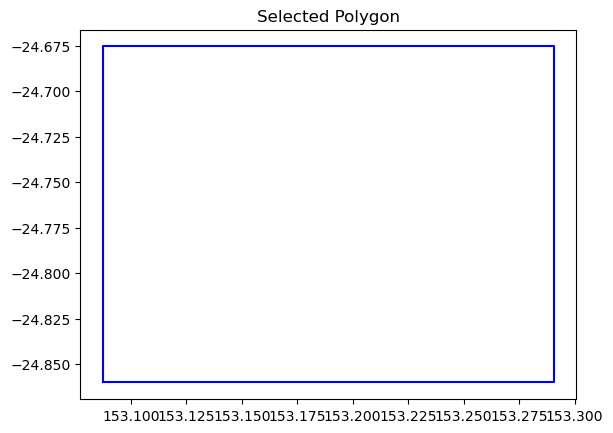

Section 3: Display Selected Coordinates - Completed


In [3]:
import matplotlib.pyplot as plt
from pyproj import Proj
from shapely.geometry.polygon import LinearRing
import gc

# Function to convert latitude and longitude to UTM coordinates
def latlon_to_utm(lat, lon):
    utm_proj = Proj(proj="utm", zone=33, datum="WGS84")  # Change zone as needed
    utm_x, utm_y = utm_proj(lon, lat)
    return utm_x, utm_y

# Function to display the selected coordinates, UTM coordinates, and visualize the polygon
def display_selected_coordinates(selected_polygon):
    if selected_polygon is not None:
        coords = selected_polygon.exterior.coords
        utm_coords = [latlon_to_utm(lat, lon) for lon, lat in coords]

        print("The drawn shape was used for selection.")
        print("The geopolygon of interest is the following one; ")
        print(selected_polygon)

        print("\nSelected Polygon Coordinates:")
        for lon, lat in coords:
            print(f"Latitude: {lat}, Longitude: {lon}")

        print("\nUTM Coordinates:")
        for utm_x, utm_y in utm_coords:
            print(f"UTM X: {utm_x}, UTM Y: {utm_y}")

        # Visualize the selected polygon
        ring = LinearRing(coords)
        fig, ax = plt.subplots()
        ax.plot(*ring.xy, color="blue")
        ax.set_title("Selected Polygon")
        plt.show()
        
        # Explicitly clear variables and run garbage collection
        del coords, utm_coords, ring, fig, ax
        gc.collect()
    else:
        print("No polygon selected")

# Call the function to display the coordinates and visualize the polygon
# Assuming you have the selected polygon stored in a variable named 'selected_polygon'
display_selected_coordinates(selected_polygon)

print("Section 3: Display Selected Coordinates - Completed")


# Section 4 - Date Selection

In [4]:
from datetime import datetime
from IPython.display import display
from ipywidgets import widgets
import gc

# Define a function to update and print the time range
def update_time_range(start_date, end_date):
    time_range = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
    print(f"Selected time range: {time_range}")
    return time_range

# Input widgets for specifying the year range
start_date_input = widgets.DatePicker(
    description="Start Date", value=datetime(2010, 1, 1)  # Default value (example)
)

end_date_input = widgets.DatePicker(
    description="End Date", value=datetime(2020, 12, 31)  # Default value (example)
)

# Display date pickers
display(start_date_input, end_date_input)

# Attach the update function to the date pickers
def on_date_change(change):
    update_time_range(start_date_input.value, end_date_input.value)

start_date_input.observe(on_date_change, names='value')
end_date_input.observe(on_date_change, names='value')

# Initial call to set the time range
time_range = update_time_range(start_date_input.value, end_date_input.value)

# Free up memory if necessary
_ = gc.collect()  # Store the result in a variable to avoid displaying it


DatePicker(value=datetime.datetime(2010, 1, 1, 0, 0), description='Start Date', step=1)

DatePicker(value=datetime.datetime(2020, 12, 31, 0, 0), description='End Date', step=1)

Selected time range: ('2010-01-01', '2020-12-31')


# Section 5 - DEA Data Load

In [5]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import HTML, VBox
from IPython.display import display
import time
import logging
import threading
import gc

# Suppress garbage collection warnings
logging.getLogger("distributed.utils_perf").setLevel(logging.ERROR)

# Create a dot indicator
spinner = HTML("<b>.</b>")
box = VBox([spinner])
display(box)

# Function to update the spinner
def spin():
    while not done:
        spinner.value = spinner.value + "." if len(spinner.value) < 10 else "<b>.</b>"
        time.sleep(0.5)

# Assume total steps is the number of files/jobs being loaded
total_steps = 10  # Replace with the actual number of steps

# Ensure actual data loading for DEA Land Cover data
done = False
try:
    # Start the spinner in a separate thread
    spinner_thread = threading.Thread(target=spin)
    spinner_thread.start()
    
    # Step 1: Check if required variables are defined
    if lat_range is None or lon_range is None or start_date_input.value is None or end_date_input.value is None:
        raise ValueError("Latitude, Longitude, or Time range is not defined")

    print("Lat Range:", lat_range)
    print("Lon Range:", lon_range)
    print("Start Date:", start_date_input.value)
    print("End Date:", end_date_input.value)

    # Step 2: Construct the query
    query = {
        "y": lat_range,
        "x": lon_range,
        "time": (start_date_input.value, end_date_input.value),
    }

    print("Query Parameters:", query)

    # Step 3: Load DEA Land Cover data from the datacube
    with tqdm(total=total_steps, desc="Loading DEA Land Cover data", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
        lc = dc.load(
            product="ga_ls_landcover_class_cyear_2",
            output_crs="EPSG:3577",
            measurements=[
                "level3",
                "lifeform",
                "vegetation_cover",
                "water_seasonality",
                "water_state",
                "intertidal",
                "water_persistence",
                "bare_gradation",
                "full_classification",
            ],
            resolution=(-25, 25),
            dask_chunks={'time': 1},
            **query
        ).persist()
        # Update the progress bar after each step
        pbar.update(1)  # Adjust the value if multiple steps are combined into one

        # Simulate further steps if necessary
        for _ in range(total_steps - 1):
            time.sleep(0.1)  # Simulate a step taking time
            pbar.update(1)

    pbar.close()  # Close the progress bar to remove it from the output
    print("DEA Land Cover data loaded successfully.")
except Exception as e:
    print(f"Error loading DEA Land Cover data: {e}")
finally:
    # Stop the spinner
    done = True
    spinner_thread.join()

# Remove the spinner
box.close()

# Step 4: Check if the dataset is loaded correctly
if 'lc' not in locals() or lc is None or lc.geobox is None:
    raise ValueError("Failed to load the dataset. Please check the query parameters and ensure data is available for the specified region and time range.")   

# Step 5: Print geobox information
geobox = lc.geobox

geobox_info = f"""
Geobox Information:
-------------------
CRS: {geobox.crs}
Dimensions: {geobox.dimensions}
Resolution: {geobox.resolution}
Shape: {geobox.shape}
Extent: {geobox.extent}
"""

print(geobox_info)

# Step 6: Check loaded data dimensions and variables
print("Loaded data dimensions:", lc.dims)
print("Loaded data variables:", lc.data_vars)

# Free up memory if necessary
_ = gc.collect()  # Suppress the output by assigning it to a variable


Lat Range: (-24.860078, -24.675527)
Lon Range: (153.087283, 153.29053)
Start Date: 2010-01-01 00:00:00
End Date: 2020-12-31 00:00:00
Query Parameters: {'y': (-24.860078, -24.675527), 'x': (153.087283, 153.29053), 'time': (datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0))}


Loading DEA Land Cover data:   0%|          | 0/10 [00:00<?]

DEA Land Cover data loaded successfully.

Geobox Information:
-------------------
CRS: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]]
Dimensions: ('y', 'x')
Resolution: (-25.0, 25.0)
Shape: (951, 940)
Extent: Geometry({'type': 'Polygon', 'coordinates': (((2097450.0, -2839975.0), (2097450.0, -2863750.0), (2120950.0, -2863750.0), (2120950.0, -2839975.0), (2097450.0, -2839975

# Sections 5b-f - Optional (No need to run)

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import HTML, VBox
from IPython.display import display
import time
import logging
import threading
import gc

# Suppress garbage collection warnings
logging.getLogger("distributed.utils_perf").setLevel(logging.ERROR)

# Define the mask_invalid_data function
def mask_invalid_data(data):
    return data.where(data != -9999)

# Create a dot indicator
spinner = HTML("<b>.</b>")
box = VBox([spinner])
display(box)

# Function to update the spinner
def spin():
    while not done:
        spinner.value = spinner.value + "." if len(spinner.value) < 10 else "<b>.</b>"
        time.sleep(0.5)

# Assume total steps is the number of files/jobs being loaded
total_steps = 3  # Adjust based on the number of actual steps

# Ensure actual data loading for Landsat geomedian data
done = False
try:
    # Start the spinner in a separate thread
    spinner_thread = threading.Thread(target=spin)
    spinner_thread.start()
    
    # Start the progress bar
    with tqdm(total=total_steps, desc="Loading Landsat Geomedian data", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
        
        # Load the Landsat geomedian (optional)
        geomad = dc.load(
            product="ga_ls8c_nbart_gm_cyear_3",
            measurements=["red", "green", "blue"],
            resampling="cubic", like=lc,
        )
        pbar.update(1)  # Update after loading the data

        geomad = mask_invalid_data(geomad)
        pbar.update(1)  # Update after masking the data

        print("Landsat Geomedian data loaded successfully.")
        pbar.update(1)  # Final update to 100%
    pbar.close()  # Close the progress bar to remove it from the output
except Exception as e:
    print(f"Error loading Landsat Geomedian data: {e}")
finally:
    # Stop the spinner
    done = True
    spinner_thread.join()

# Remove the spinner
box.close()

# Free up memory if necessary
_ = gc.collect()  # Suppress the output by assigning it to a variable



In [6]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import HTML, VBox
from IPython.display import display
import time
import logging
import threading
import gc

# Suppress garbage collection warnings
logging.getLogger("distributed.utils_perf").setLevel(logging.ERROR)

# Create a dot indicator
spinner = HTML("<b>.</b>")
box = VBox([spinner])
display(box)

# Function to update the spinner
def spin():
    while not done:
        spinner.value = spinner.value + "." if len(spinner.value) < 10 else "<b>.</b>"
        time.sleep(0.5)

# Assume total steps is the number of files/jobs being loaded
total_steps = 3  # Adjust based on the number of actual steps

# Ensure actual data loading for intertidal elevation products
done = False
try:
    # Start the spinner in a separate thread
    spinner_thread = threading.Thread(target=spin)
    spinner_thread.start()
    
    # Start the progress bar
    with tqdm(total=total_steps, desc="Loading Intertidal Elevation data", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
        
        # Load and mask the Intertidal Elevation products (select measurement = elevation, elevation_uncertainty and exposure)
        item = dc.load(
            product="ga_s2ls_intertidal_cyear_3",
            like=lc
        )
        pbar.update(1)  # Update after loading the data

        item = mask_invalid_data(item)
        pbar.update(1)  # Update after masking the data

        item = item.where(item != 0)
        pbar.update(1)  # Update after filtering the data

        print("Intertidal Elevation data loaded successfully.")
    pbar.close()  # Close the progress bar to remove it from the output
except Exception as e:
    print(f"Error loading Intertidal Elevation data: {e}")
finally:
    # Stop the spinner
    done = True
    spinner_thread.join()

# Remove the spinner
box.close()

# Free up memory if necessary
_ = gc.collect()  # Suppress the output by assigning it to a variable


Loading Intertidal Elevation data:   0%|          | 0/3 [00:00<?]

Intertidal Elevation data loaded successfully.


In [7]:
import os
from datacube.testutils.io import rio_slurp_xarray
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import HTML, VBox
from IPython.display import display
import time
import logging
import threading
import gc

# Suppress garbage collection warnings
logging.getLogger("distributed.utils_perf").setLevel(logging.ERROR)

# Create a dot indicator
spinner = HTML("<b>.</b>")
box = VBox([spinner])
display(box)

# Function to update the spinner
def spin():
    while not done:
        spinner.value = spinner.value + "." if len(spinner.value) < 10 else "<b>.</b>"
        time.sleep(0.5)

# Define paths to datasets
base_path = "/home/jovyan/Uploads/ABG/S20E150_Qld_SEast/"
AGB_paths = {
    2010: os.path.join(base_path, "S20E150_2010_AGBcz.tif"),
    2015: os.path.join(base_path, "S20E150_2015_AGBcz.tif"),
    2016: os.path.join(base_path, "S20E150_2016_AGBcz.tif"),
    2017: os.path.join(base_path, "S20E150_2017_AGBcz.tif"),
    2018: os.path.join(base_path, "S20E150_2018_AGBcz.tif"),
    2019: os.path.join(base_path, "S20E150_2019_AGBcz.tif"),
    2020: os.path.join(base_path, "S20E150_2020_AGBcz.tif"),
    2021: os.path.join(base_path, "S20E150_2021_AGBcz.tif")
}

SD_paths = {
    2010: os.path.join(base_path, "S20E150_2010_SDcz.tif"),
    2015: os.path.join(base_path, "S20E150_2015_SDcz.tif"),
    2016: os.path.join(base_path, "S20E150_2016_SDcz.tif"),
    2017: os.path.join(base_path, "S20E150_2017_SDcz.tif"),
    2018: os.path.join(base_path, "S20E150_2018_SDcz.tif"),
    2019: os.path.join(base_path, "S20E150_2019_SDcz.tif"),
    2020: os.path.join(base_path, "S20E150_2020_SDcz.tif"),
    2021: os.path.join(base_path, "S20E150_2021_SDcz.tif")
}

# Print the current working directory and the paths to ensure they are correct
print(f"Current Working Directory: {os.getcwd()}")
print(f"AGB Paths: {AGB_paths}")
print(f"SD Paths: {SD_paths}")

# Check if files exist
agb_files_exist = all(os.path.exists(path) for path in AGB_paths.values())
sd_files_exist = all(os.path.exists(path) for path in SD_paths.values())

if not agb_files_exist or not sd_files_exist:
    print("Error: One or more files do not exist.")
    for year, path in AGB_paths.items():
        if not os.path.exists(path):
            print(f"AGB file for {year} not found: {path}")
    for year, path in SD_paths.items():
        if not os.path.exists(path):
            print(f"SD file for {year} not found: {path}")
else:
    # Ensure actual data loading and resampling for datasets
    done = False
    total_steps = len(AGB_paths) + len(SD_paths)  # Total number of files to be loaded

    try:
        # Start the spinner in a separate thread
        spinner_thread = threading.Thread(target=spin)
        spinner_thread.start()
        
        # Start the progress bar
        with tqdm(total=total_steps, desc="Loading and Resampling datasets", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
            
            # Proceed with loading and resampling if all files exist
            try:
                AGB_datasets = {}
                SD_datasets = {}
                
                for year in AGB_paths.keys():
                    AGB_datasets[year] = rio_slurp_xarray(AGB_paths[year], lc.geobox, resampling="nearest")
                    pbar.update(1)
                
                for year in SD_paths.keys():
                    SD_datasets[year] = rio_slurp_xarray(SD_paths[year], lc.geobox, resampling="nearest")
                    pbar.update(1)
                
                print("Datasets loaded and resampled successfully.")
            
            except Exception as e:
                print(f"Error loading or resampling datasets: {e}")
        pbar.close()  # Close the progress bar to remove it from the output
    except Exception as e:
        print(f"Error in processing datasets: {e}")
    finally:
        # Stop the spinner
        done = True
        spinner_thread.join()

    # Remove the spinner
    box.close()

    # Free up memory if necessary
    _ = gc.collect()  # Suppress the output by assigning it to a variable


Current Working Directory: /home/jovyan/Living_Coasts_training
AGB Paths: {2010: '/home/jovyan/Uploads/ABG/S20E150_Qld_SEast/S20E150_2010_AGBcz.tif', 2015: '/home/jovyan/Uploads/ABG/S20E150_Qld_SEast/S20E150_2015_AGBcz.tif', 2016: '/home/jovyan/Uploads/ABG/S20E150_Qld_SEast/S20E150_2016_AGBcz.tif', 2017: '/home/jovyan/Uploads/ABG/S20E150_Qld_SEast/S20E150_2017_AGBcz.tif', 2018: '/home/jovyan/Uploads/ABG/S20E150_Qld_SEast/S20E150_2018_AGBcz.tif', 2019: '/home/jovyan/Uploads/ABG/S20E150_Qld_SEast/S20E150_2019_AGBcz.tif', 2020: '/home/jovyan/Uploads/ABG/S20E150_Qld_SEast/S20E150_2020_AGBcz.tif', 2021: '/home/jovyan/Uploads/ABG/S20E150_Qld_SEast/S20E150_2021_AGBcz.tif'}
SD Paths: {2010: '/home/jovyan/Uploads/ABG/S20E150_Qld_SEast/S20E150_2010_SDcz.tif', 2015: '/home/jovyan/Uploads/ABG/S20E150_Qld_SEast/S20E150_2015_SDcz.tif', 2016: '/home/jovyan/Uploads/ABG/S20E150_Qld_SEast/S20E150_2016_SDcz.tif', 2017: '/home/jovyan/Uploads/ABG/S20E150_Qld_SEast/S20E150_2017_SDcz.tif', 2018: '/home/jovya

In [8]:
import os
import datacube
from datacube.testutils.io import rio_slurp_xarray
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import HTML, VBox, IntProgress
from IPython.display import display
import time
import threading
import logging
import gc

# Suppress garbage collection warnings
logging.getLogger("distributed.utils_perf").setLevel(logging.ERROR)

# Function to create a spinner and progress bar
def create_spinner():
    spinner = HTML("<b>.</b>")
    percentage_bar = IntProgress(min=0, max=100, description='Progress:', bar_style='info')
    box = VBox([spinner, percentage_bar])
    display(box)
    return spinner, percentage_bar, box

# Function to spin the spinner
def spin_spinner(spinner, done):
    def spin():
        while not done[0]:
            spinner.value = spinner.value + "." if len(spinner.value) < 10 else "<b>.</b>"
            time.sleep(0.5)
    return spin

# Function to update the progress bar
def update_progress(step_counter, total_steps, percentage_bar):
    step_counter += 1
    percentage_bar.value = int((step_counter / total_steps) * 100)
    return step_counter

# Function to load and process datasets
def load_and_process_datasets(paths, geobox, total_steps, description):
    datasets = {}
    done = [False]
    step_counter = 0
    spinner, percentage_bar, box = create_spinner()
    spinner_thread = threading.Thread(target=spin_spinner(spinner, done))
    spinner_thread.start()

    try:
        for year, path in paths.items():
            datasets[year] = rio_slurp_xarray(path, geobox, resampling="nearest")
            step_counter = update_progress(step_counter, total_steps, percentage_bar)
        print(f"{description} loaded successfully.")
    except Exception as e:
        print(f"Error loading {description}: {e}")
    finally:
        done[0] = True
        spinner_thread.join()
        box.close()
        gc.collect()  # Free up memory

    return datasets

# Function to mask and filter datasets
def mask_and_filter_datasets(datasets, total_steps, description):
    processed_datasets = {}
    done = [False]
    step_counter = 0
    spinner, percentage_bar, box = create_spinner()
    spinner_thread = threading.Thread(target=spin_spinner(spinner, done))
    spinner_thread.start()

    try:
        for year, data in datasets.items():
            data = mask_invalid_data(data)
            step_counter = update_progress(step_counter, total_steps, percentage_bar)
            data = data.where(data != 0)
            step_counter = update_progress(step_counter, total_steps, percentage_bar)
            processed_datasets[year] = data
            step_counter = update_progress(step_counter, total_steps, percentage_bar)
        print(f"{description} processed successfully.")
    except Exception as e:
        print(f"Error processing {description}: {e}")
    finally:
        done[0] = True
        spinner_thread.join()
        box.close()
        gc.collect()  # Free up memory

    return processed_datasets

# Function to generate differences and uncertainties
def generate_differences_and_uncertainties(AGB_datasets, SD_datasets):
    AGB = AGB_datasets[2010].to_dataset(name="AGB2010")
    for year in range(2015, 2022):
        AGB[f"AGB{year}"] = AGB_datasets[year]

    differences = {}
    for start, end in [(2010, 2020), (2010, 2015), (2015, 2016), (2016, 2017), (2017, 2018), (2018, 2019), (2019, 2020), (2020, 2021), (2017, 2020)]:
        differences[f"d{start}_{end}"] = AGB[f"AGB{end}"].fillna(0) - AGB[f"AGB{start}"].fillna(0)

    diff_biomass = differences["d2010_2020"].where(differences["d2010_2020"] != 0).to_dataset(name="d2010_2020")
    for key, diff in differences.items():
        diff_biomass[key] = diff.where(diff != 0)

    SD = SD_datasets[2010].to_dataset(name="SD2010")
    for year in range(2015, 2022):
        SD[f"SD{year}"] = SD_datasets[year]

    AGB_min = {}
    AGB_max = {}
    for year in [2010, 2015, 2016, 2017, 2018, 2019, 2020, 2021]:
        AGB_min[year] = AGB[f"AGB{year}"] - SD[f"SD{year}"]
        AGB_max[year] = AGB[f"AGB{year}"] + SD[f"SD{year}"]

    min_biomass = AGB_min[2010].to_dataset(name="AGB2010_Min")
    max_biomass = AGB_max[2010].to_dataset(name="AGB2010_Max")
    for year in [2015, 2016, 2017, 2018, 2019, 2020, 2021]:
        min_biomass[f"AGB{year}_Min"] = AGB_min[year]
        max_biomass[f"AGB{year}_Max"] = AGB_max[year]

    gc.collect()  # Free up memory
    return diff_biomass, min_biomass, max_biomass



In [9]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datacube.testutils.io import rio_slurp_xarray
from tqdm.notebook import tqdm
from ipywidgets import HTML, VBox, IntProgress
from IPython.display import display
import threading
import time

# Function to load datasets
def load_datasets(paths, geobox, description):
    datasets = {}
    total_files = len(paths)
    step_counter = 0
    
    # Create a dot indicator and progress bar
    spinner = HTML("<b>.</b>")
    percentage_bar = IntProgress(min=0, max=100, description='Progress:', bar_style='info')
    box = VBox([spinner, percentage_bar])
    display(box)

    # Function to update the spinner
    def spin():
        while not done:
            spinner.value = spinner.value + "." if len(spinner.value) < 10 else "<b>.</b>"
            time.sleep(0.5)

    # Set up threading for the spinner
    done = False
    spinner_thread = threading.Thread(target=spin)
    spinner_thread.start()

    try:
        for year, path in tqdm(paths.items(), desc=f"Loading {description}"):
            datasets[year] = rio_slurp_xarray(path, geobox, resampling="nearest")
            step_counter += 1
            percentage_bar.value = int((step_counter / total_files) * 100)
    except Exception as e:
        print(f"Error loading {description}: {e}")
    finally:
        done = True
        spinner_thread.join()
        box.close()
    
    return datasets

# Function to process datasets
def process_datasets(datasets, description):
    total_steps = len(datasets) * 2  # Each dataset has two steps (load and process)
    step_counter = 0

    # Create a dot indicator and progress bar
    spinner = HTML("<b>.</b>")
    percentage_bar = IntProgress(min=0, max=100, description='Progress:', bar_style='info')
    box = VBox([spinner, percentage_bar])
    display(box)

    # Function to update the spinner
    def spin():
        while not done:
            spinner.value = spinner.value + "." if len(spinner.value) < 10 else "<b>.</b>"
            time.sleep(0.5)

    # Set up threading for the spinner
    done = False
    spinner_thread = threading.Thread(target=spin)
    spinner_thread.start()

    try:
        processed_datasets = {}
        for year, dataset in tqdm(datasets.items(), desc=f"Processing {description}"):
            # Apply mask_invalid_data function
            processed_dataset = mask_invalid_data(dataset)
            step_counter += 1
            percentage_bar.value = int((step_counter / total_steps) * 100)

            # Apply where function
            processed_dataset = processed_dataset.where(processed_dataset != 0)
            processed_datasets[year] = processed_dataset
            step_counter += 1
            percentage_bar.value = int((step_counter / total_steps) * 100)
    except Exception as e:
        print(f"Error processing {description}: {e}")
    finally:
        done = True
        spinner_thread.join()
        box.close()
    
    return processed_datasets

# Function to generate differences and uncertainties
def generate_differences_and_uncertainties(AGB_datasets, SD_datasets):
    total_steps = 10  # Adjust based on actual steps
    step_counter = 0

    # Create a dot indicator and progress bar
    spinner = HTML("<b>.</b>")
    percentage_bar = IntProgress(min=0, max=100, description='Progress:', bar_style='info')
    box = VBox([spinner, percentage_bar])
    display(box)

    # Function to update the spinner
    def spin():
        while not done:
            spinner.value = spinner.value + "." if len(spinner.value) < 10 else "<b>.</b>"
            time.sleep(0.5)

    # Set up threading for the spinner
    done = False
    spinner_thread = threading.Thread(target=spin)
    spinner_thread.start()

    diff_biomass = None
    min_biomass = None
    max_biomass = None

    try:
        # Step 1: Generate uncertainties based on stock differences
        AGB = AGB_datasets[2010].to_dataset(name="AGB2010")
        for year in [2015, 2016, 2017, 2018, 2019, 2020, 2021]:
            AGB[f"AGB{year}"] = AGB_datasets[year]
            step_counter += 1
            percentage_bar.value = int((step_counter / total_steps) * 100)

        diff_biomass = {}
        for year_pair in [(2010, 2020), (2010, 2015), (2015, 2016), (2016, 2017), (2017, 2018), (2018, 2019), (2019, 2020), (2020, 2021), (2017, 2020)]:
            start_year, end_year = year_pair
            diff = AGB[f"AGB{end_year}"].fillna(0) - AGB[f"AGB{start_year}"].fillna(0)
            diff_biomass[f"d{start_year}_{end_year}"] = diff.where(diff != 0).to_dataset(name=f"d{start_year}_{end_year}")
            step_counter += 1
            percentage_bar.value = int((step_counter / total_steps) * 100)

        SD = SD_datasets[2010].to_dataset(name="SD2010")
        for year in [2015, 2016, 2017, 2018, 2019, 2020, 2021]:
            SD[f"SD{year}"] = SD_datasets[year]
            step_counter += 1
            percentage_bar.value = int((step_counter / total_steps) * 100)

        min_biomass = {f"AGB{year}_Min": AGB[f"AGB{year}"] - SD[f"SD{year}"] for year in [2010, 2015, 2016, 2017, 2018, 2019, 2020, 2021]}
        max_biomass = {f"AGB{year}_Max": AGB[f"AGB{year}"] + SD[f"SD{year}"] for year in [2010, 2015, 2016, 2017, 2018, 2019, 2020, 2021]}
        step_counter += 1
        percentage_bar.value = int((step_counter / total_steps) * 100)
    except Exception as e:
        print(f"Error generating differences and uncertainties: {e}")
    finally:
        done = True
        spinner_thread.join()
        box.close()

    return diff_biomass, min_biomass, max_biomass

# Define paths to datasets
base_path = "/home/jovyan/Uploads/ABG/S20E150_Qld_SEast/"
AGB_paths = {
    2010: os.path.join(base_path, "S20E150_2010_AGBcz.tif"),
    2015: os.path.join(base_path, "S20E150_2015_AGBcz.tif"),
    2016: os.path.join(base_path, "S20E150_2016_AGBcz.tif"),
    2017: os.path.join(base_path, "S20E150_2017_AGBcz.tif"),
    2018: os.path.join(base_path, "S20E150_2018_AGBcz.tif"),
    2019: os.path.join(base_path, "S20E150_2019_AGBcz.tif"),
    2020: os.path.join(base_path, "S20E150_2020_AGBcz.tif"),
    2021: os.path.join(base_path, "S20E150_2021_AGBcz.tif")
}

SD_paths = {
    2010: os.path.join(base_path, "S20E150_2010_SDcz.tif"),
    2015: os.path.join(base_path, "S20E150_2015_SDcz.tif"),
    2016: os.path.join(base_path, "S20E150_2016_SDcz.tif"),
    2017: os.path.join(base_path, "S20E150_2017_SDcz.tif"),
    2018: os.path.join(base_path, "S20E150_2018_SDcz.tif"),
    2019: os.path.join(base_path, "S20E150_2019_SDcz.tif"),
    2020: os.path.join(base_path, "S20E150_2020_SDcz.tif"),
    2021: os.path.join(base_path, "S20E150_2021_SDcz.tif")
}

# Load datasets
AGB_datasets = load_datasets(AGB_paths, lc.geobox, "AGB datasets")
SD_datasets = load_datasets(SD_paths, lc.geobox, "SD datasets")

# Process datasets
processed_AGB_datasets = process_datasets(AGB_datasets, "AGB datasets")
processed_SD_datasets = process_datasets(SD_datasets, "SD datasets")

# Generate differences and uncertainties
diff_biomass, min_biomass, max_biomass = generate_differences_and_uncertainties(processed_AGB_datasets, processed_SD_datasets)


Loading AGB datasets:   0%|          | 0/8 [00:00<?, ?it/s]

Error loading AGB datasets: /home/jovyan/Uploads/ABG/S20E150_Qld_SEast/S20E150_2010_AGBcz.tif: No such file or directory


Loading SD datasets:   0%|          | 0/8 [00:00<?, ?it/s]

Error loading SD datasets: /home/jovyan/Uploads/ABG/S20E150_Qld_SEast/S20E150_2010_SDcz.tif: No such file or directory


Processing AGB datasets: 0it [00:00, ?it/s]

Processing SD datasets: 0it [00:00, ?it/s]

Error generating differences and uncertainties: 2010


# Section 6 - Checkbox Plots

In [10]:
import matplotlib.pyplot as plt
from ipywidgets import Checkbox, VBox, HBox, Button, Output, HTML
from IPython.display import display
from dea_tools.landcover import plot_land_cover

# Section 6: Checkbox widgets for selecting datasets
def create_checkbox(description, initial_value=False):
    return Checkbox(description=description, value=initial_value)

level3_checkbox = create_checkbox('Level 3')
lifeform_checkbox = create_checkbox('Lifeform')
vegetation_cover_checkbox = create_checkbox('Vegetation Cover')
water_state_checkbox = create_checkbox('Water State')
water_persistence_checkbox = create_checkbox('Water Persistence')
full_classification_checkbox = create_checkbox('Full Classification')
item_checkbox = create_checkbox('Intertidal Elevation')

output = Output()

def plot_land_cover_dataset(dataset, title):
    plt.figure()
    plot_land_cover(dataset)
    plt.title(title)
    plt.show()

def plot_selected_datasets():
    with output:
        output.clear_output()
        selected_datasets = {
            'Level 3': (level3_checkbox.value, lc.level3 if 'lc' in globals() else None),
            'Lifeform': (lifeform_checkbox.value, lc.lifeform if 'lc' in globals() else None),
            'Vegetation Cover': (vegetation_cover_checkbox.value, lc.vegetation_cover if 'lc' in globals() else None),
            'Water State': (water_state_checkbox.value, lc.water_state if 'lc' in globals() else None),
            'Water Persistence': (water_persistence_checkbox.value, lc.water_persistence if 'lc' in globals() else None),
            'Full Classification': (full_classification_checkbox.value, lc.full_classification if 'lc' in globals() else None),
            'Intertidal Elevation': (item_checkbox.value, item.elevation[0] if 'item' in globals() else None)
        }

        for title, (is_selected, dataset) in selected_datasets.items():
            if is_selected and dataset is not None:
                plot_land_cover_dataset(dataset, title)
                del dataset  # Free up memory

plot_datasets_button = Button(description='Plot Selected Data')
plot_datasets_button.on_click(lambda b: plot_selected_datasets())

checkboxes_box = HBox([
    level3_checkbox, 
    lifeform_checkbox, 
    vegetation_cover_checkbox, 
    water_state_checkbox, 
    water_persistence_checkbox, 
    full_classification_checkbox,
    item_checkbox
])
display(checkboxes_box)
display(plot_datasets_button)
display(output)


Button(description='Plot Selected Data', style=ButtonStyle())

Output()

# Section 7 - Impacts and Pressure Selection

In [17]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML

# Load the dataset from the specified relative path
file_path = './gct/Impacts and pressures.xlsx'
df = pd.read_excel(file_path, sheet_name='Australia')

# Replace NaN values in 'Impact_ID' and 'Pressure_ID' columns with zeros
df['Impact_ID'] = df['Impact_ID'].fillna(0).astype(int)
df['Pressure_ID'] = df['Pressure_ID'].fillna(0).astype(int)

# Create a mapping from Impact to associated Pressures
impact_to_pressures = df.groupby(['Impacts', 'Impact_ID'])[['Pressures', 'Pressure_ID']].apply(
    lambda x: [f"{row['Pressures']} ({row['Pressure_ID']})" for _, row in x.iterrows()]
).to_dict()

# Define evidence groups
time_columns = ['TimeO_Ev', 'TimeL_Ev', 'TimeM_Ev', 'TimeD_Ev', 'Space_Ev']
level3_columns = ['Level3a_Ev', 'Level3b_Ev', 'Level3c_Ev', 'Level3d_Ev', 'Level3e_Ev', 'Level3f_Ev', 'Level3g_Ev']
lifeform_columns = ['Lifeforma_Ev', 'Lifeformb_Ev', 'Lifeformc_Ev', 'Lifeformd_Ev']
water_columns = ['Waterpera_Ev', 'Waterperb_Ev', 'Waterperc_Ev', 'Waterperd_Ev', 'Waterpere_Ev', 'Waterperf_Ev']
biomass_columns = ['AGB_Ev', 'AGBSD_Ev']
individual_columns = ['Canopycoa_Ev', 'Fire presence', 'Turbidity']

# Create a dictionary to map each identifier to its associated evidence with values
identifier_to_evidence = {}
for _, row in df.iterrows():
    identifier = row['Impact_ID'] * 1000 + row['Pressure_ID']
    
    # Function to format values
    def format_value(value):
        try:
            return int(value) if pd.notnull(value) and value == int(value) else value
        except (ValueError, TypeError):
            return value

    evidence_with_values = {
        'IP_UID': row['IP_UID'],
        'ID_Colour': row['ID_Colour'],
        'Time_Evidence': [(col, format_value(row[col])) for col in time_columns if pd.notnull(row[col])],
        'Level3_Evidence': [(col, format_value(row[col])) for col in level3_columns if pd.notnull(row[col])],
        'Lifeform_Evidence': [(col, format_value(row[col])) for col in lifeform_columns if pd.notnull(row[col])],
        'Water_Evidence': [(col, format_value(row[col])) for col in water_columns if pd.notnull(row[col])],
        'Biomass_Evidence': [(col, format_value(row[col])) for col in biomass_columns if pd.notnull(row[col])],
        'Individual_Evidence': [(col, format_value(row[col])) for col in individual_columns if pd.notnull(row[col])]
    }
    identifier_to_evidence[identifier] = evidence_with_values

# Create the dropdown widgets for impacts and pressures with IDs
impact_dropdown = widgets.Dropdown(
    options=[f"{impact} ({impact_id})" for (impact, impact_id) in impact_to_pressures.keys()],
    description='Impact:',
    value=None  # Start without a selection
)

pressure_dropdown = widgets.Dropdown(
    options=['Please select an Impact first'],
    description='Pressure:',
    value=None  # Start without a selection
)

# Define the output widget for displaying the calculation result and evidence
output = widgets.Output()

# Define the function to update pressure dropdown based on selected impact
def on_impact_change(change):
    selected_impact = change['new']
    if selected_impact:
        impact, impact_id = selected_impact.rsplit(' (', 1)
        impact_id = int(impact_id.rstrip(')'))
        pressures = impact_to_pressures.get((impact, impact_id), [])
        pressure_dropdown.options = pressures
    else:
        pressure_dropdown.options = ['Please select an Impact first']

# Define the function to display the selected impact and pressure
def display_selection(impact, pressure):
    global selected_ip_uid  # Make IP_UID global to be accessible in Section 8

    with output:
        output.clear_output()
        if impact and pressure:
            impact_id = int(impact.rsplit(' (', 1)[1].rstrip(')'))
            pressure_id = int(pressure.rsplit(' (', 1)[1].rstrip(')'))
            identifier = impact_id * 1000 + pressure_id

            if identifier in identifier_to_evidence:
                evidence = identifier_to_evidence[identifier]
                selected_ip_uid = evidence["IP_UID"]  # Set the selected IP_UID
                display(HTML(f'<strong>Selected Impact:</strong> {impact}'))
                display(HTML(f'<strong>Selected Pressure:</strong> {pressure}'))
                display(HTML(f'<strong>Identifier:</strong> {identifier}'))
                display(HTML(f'<strong>IP_UID:</strong> {evidence["IP_UID"]}'))
                display(HTML(f'<strong>ID_Colour:</strong> {evidence["ID_Colour"]}'))
                display(HTML('<strong>Evidence:</strong>'))
                for group, values in evidence.items():
                    if group not in ['IP_UID', 'ID_Colour'] and values:
                        display(HTML(f'<strong>{group.replace("_", " ")}:</strong>'))
                        for evidence_name, value in values:
                            display(HTML(f'- {evidence_name}: {value}'))
            else:
                display(HTML('<strong>Error:</strong> No evidence found for the selected Impact and Pressure.'))
        else:
            display(HTML('<strong>Please select both an impact and a pressure.</strong>'))

# Set up observation for changes in the impact dropdown
impact_dropdown.observe(on_impact_change, names='value')

# Set up interaction to display selections
interactive_selection = widgets.interactive(display_selection, impact=impact_dropdown, pressure=pressure_dropdown)

# Arrange the widgets and the output display
display(widgets.VBox([impact_dropdown, pressure_dropdown, output]))

# Free up memory by removing the dataframe
del df


# Section 8 - Impacts and Pressure Evidence

In [13]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# Ensure actual data loading is in place of random data
# Load actual data for level3 and lifeform changes
start_l3 = lc.level3[0].astype(np.int32)
end_l3 = lc.level3[-1].astype(np.int32)
ignore_no_change = False
change_vals_l3 = (start_l3 * 1000) + end_l3
if ignore_no_change:
    change_vals_l3 = np.where(start_l3 == end_lf, 0, change_vals_l3)
level_3 = lc.level3[0].drop_vars("time")

obs_change_l3_2010_2020 = xr.DataArray(
    data=change_vals_l3,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)
obs_change_l3 = obs_change_l3_2010_2020.to_dataset(name="l3_2010_2020")
del obs_change_l3_2010_2020

# Load actual data for lifeform changes
start_lf = lc.lifeform[0].astype(np.int32)
end_lf = lc.lifeform[-1].astype(np.int32)
change_vals_lf = (start_lf * 10) + end_lf
if ignore_no_change:
    change_vals_lf = np.where(start_lf == end_lf, 0, change_vals_lf)
lifeform = lc.lifeform[0].drop_vars("time")

obs_change_lf_2010_2020 = xr.DataArray(
    data=change_vals_lf,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="observed change",
    attrs=lifeform.attrs,
    fastpath=False,
)
obs_change_lf = obs_change_lf_2010_2020.to_dataset(name="lf_2010_2020")
del obs_change_lf_2010_2020

# Define evidence groups
time_columns = ['TimeO_Ev', 'TimeL_Ev', 'TimeM_Ev', 'TimeD_Ev', 'Space_Ev']
water_columns = ['Waterpera_Ev', 'Waterperb_Ev', 'Waterperc_Ev', 'Waterperd_Ev', 'Waterpere_Ev', 'Waterperf_Ev']
biomass_columns = ['AGB_Ev', 'AGBSD_Ev']
individual_columns = ['Canopycoa_Ev', 'Fire presence', 'Turbidity']

# Function to create and display individual masks
def create_and_display_individual_masks():
    global selected_ip_uid

    # Debug: Print selected IP_UID
    print(f"Selected IP_UID: {selected_ip_uid}")

    # Extract the relevant evidence values based on the selected IP_UID
    evidence = next((v for k, v in identifier_to_evidence.items() if v['IP_UID'] == selected_ip_uid), None)
    if evidence is None:
        print(f"No evidence found for IP_UID {selected_ip_uid}")
        return

    selected_level3_values = [(name, value) for name, value in evidence['Level3_Evidence']]
    selected_lifeform_values = [(name, value) for name, value in evidence['Lifeform_Evidence']]
    selected_time_values = [(name, value) for name, value in evidence['Time_Evidence']]
    selected_water_values = [(name, value) for name, value in evidence['Water_Evidence']]
    selected_biomass_values = [(name, value) for name, value in evidence['Biomass_Evidence']]
    selected_individual_values = [(name, value) for name, value in evidence['Individual_Evidence']]

    # Debug: Print selected values
    print(f"Selected Level3 Values: {selected_level3_values}")
    print(f"Selected Lifeform Values: {selected_lifeform_values}")
    print(f"Selected Time Values: {selected_time_values}")
    print(f"Selected Water Values: {selected_water_values}")
    print(f"Selected Biomass Values: {selected_biomass_values}")
    print(f"Selected Individual Values: {selected_individual_values}")

    if selected_level3_values:
        # Create and plot individual masks for each Level3 value
        for name, lvl3_val in selected_level3_values:
            change_l3 = np.where(
                (obs_change_l3.l3_2010_2020 == lvl3_val),
                1,
                0
            )

            change_xr_l3 = xr.DataArray(
                data=change_l3,
                coords=obs_change_l3.coords,
                dims=obs_change_l3.dims,
                name="Change",
                attrs=None
            )

            change_ds_l3 = change_xr_l3.to_dataset(name="Change")
            
            # Plot the results
            fig, ax = plt.subplots(figsize=(10, 6))
            change_ds_l3.Change.plot(ax=ax, cmap='Reds')
            fig.suptitle(f"IP_UID: {selected_ip_uid}", fontsize=16, y=1.05)
            ax.set_title(f"{name} Change Mask for Value {lvl3_val}")
            plt.tight_layout()
            plt.show()
    
    if selected_lifeform_values:
        # Create and plot individual masks for each Lifeform value
        for name, lf_val in selected_lifeform_values:
            change_lf = np.where(
                (obs_change_lf.lf_2010_2020 == lf_val),
                1,
                0
            )

            change_xr_lf = xr.DataArray(
                data=change_lf,
                coords=obs_change_lf.coords,
                dims=obs_change_lf.dims,
                name="Change",
                attrs=None
            )

            change_ds_lf = change_xr_lf.to_dataset(name="Change")
            
            # Plot the results
            fig, ax = plt.subplots(figsize=(10, 6))
            change_ds_lf.Change.plot(ax=ax, cmap='Blues')
            fig.suptitle(f"IP_UID: {selected_ip_uid}", fontsize=16, y=1.05)
            ax.set_title(f"{name} Change Mask for Value {lf_val}")
            plt.tight_layout()
            plt.show()

    if selected_time_values:
        for name, time_val in selected_time_values:
            # Replace with actual data loading and processing for time evidence
            change_time = np.random.random((len(level_3['y']), len(level_3['x'])))

            change_xr_time = xr.DataArray(
                data=change_time,
                coords=level_3.coords,
                dims=level_3.dims,
                name="Change",
                attrs=None
            )

            change_ds_time = change_xr_time.to_dataset(name="Change")

            # Plot the results
            fig, ax = plt.subplots(figsize=(10, 6))
            change_ds_time.Change.plot(ax=ax, cmap='Greens')
            fig.suptitle(f"IP_UID: {selected_ip_uid}", fontsize=16, y=1.05)
            ax.set_title(f"{name} Change Mask for Value {time_val}")
            plt.tight_layout()
            plt.show()

    if selected_water_values:
        for name, water_val in selected_water_values:
            # Replace with actual data loading and processing for water evidence
            change_water = np.random.random((len(level_3['y']), len(level_3['x'])))

            change_xr_water = xr.DataArray(
                data=change_water,
                coords=level_3.coords,
                dims=level_3.dims,
                name="Change",
                attrs=None
            )

            change_ds_water = change_xr_water.to_dataset(name="Change")

            # Plot the results
            fig, ax = plt.subplots(figsize=(10, 6))
            change_ds_water.Change.plot(ax=ax, cmap='Purples')
            fig.suptitle(f"IP_UID: {selected_ip_uid}", fontsize=16, y=1.05)
            ax.set_title(f"{name} Change Mask for Value {water_val}")
            plt.tight_layout()
            plt.show()

    if selected_biomass_values:
        for name, biomass_val in selected_biomass_values:
            # Replace with actual data loading and processing for biomass evidence
            change_biomass = np.random.random((len(level_3['y']), len(level_3['x'])))

            change_xr_biomass = xr.DataArray(
                data=change_biomass,
                coords=level_3.coords,
                dims=level_3.dims,
                name="Change",
                attrs=None
            )

            change_ds_biomass = change_xr_biomass.to_dataset(name="Change")

            # Plot the results
            fig, ax = plt.subplots(figsize=(10, 6))
            change_ds_biomass.Change.plot(ax=ax, cmap='Oranges')
            fig.suptitle(f"IP_UID: {selected_ip_uid}", fontsize=16, y=1.05)
            ax.set_title(f"{name} Change Mask for Value {biomass_val}")
            plt.tight_layout()
            plt.show()

    if selected_individual_values:
        for name, individual_val in selected_individual_values:
            # Replace with actual data loading and processing for individual evidence
            change_individual = np.random.random((len(level_3['y']), len(level_3['x'])))

            change_xr_individual = xr.DataArray(
                data=change_individual,
                coords=level_3.coords,
                dims=level_3.dims,
                name="Change",
                attrs=None
            )

            change_ds_individual = change_xr_individual.to_dataset(name="Change")

            # Plot the results
            fig, ax = plt.subplots(figsize=(10, 6))
            change_ds_individual.Change.plot(ax=ax, cmap='YlGn')
            fig.suptitle(f"IP_UID: {selected_ip_uid}", fontsize=16, y=1.05)
            ax.set_title(f"{name} Change Mask for Value {individual_val}")
            plt.tight_layout()
            plt.show()

# Call the function to create and display the masks
create_and_display_individual_masks()


Selected IP_UID: 168
Selected Level3 Values: []
Selected Lifeform Values: []
Selected Time Values: []
Selected Water Values: []
Selected Biomass Values: []
Selected Individual Values: []


# Section 9 - Testing Pressure 44 - To Do

# Section 10 - Biomass Change Differencing ABG 

# Test 10 Debug

## Step 1

In [ ]:
import os
import ipywidgets as widgets
from IPython.display import display, clear_output

# Define the base directory containing the data folders
base_dir = "./Uploads/ABG/"

# List all visible folders in the base directory (excluding hidden ones)
folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f)) and not f.startswith('.')]

# Create a dropdown menu to select a folder
folder_dropdown = widgets.Dropdown(
    options=folders,
    description='Folder:',
    disabled=False,
)

# Create an output widget to display the selected folder path
output = widgets.Output()

# Function to update the selected folder path
def update_selected_folder_path(change):
    selected_folder_path = os.path.join(base_dir, change['new'])
    with output:
        clear_output()
        print("Selected Folder Path:", selected_folder_path)

# Attach the update function to the folder dropdown
folder_dropdown.observe(update_selected_folder_path, names='value')

# Display the dropdown menu and output widget
display(folder_dropdown)
display(output)

# Initialize the output with the first folder
update_selected_folder_path({'new': folders[0]})

# Function to get the selected folder path
def get_selected_folder_path():
    return os.path.join(base_dir, folder_dropdown.value)


## Step 2

In [ ]:
import xarray as xr
import numpy as np
import datacube
from datacube.utils.masking import mask_invalid_data
from datacube.testutils.io import rio_slurp_xarray
from affine import Affine

# Define the lc object and its geobox attribute (assuming it's related to land cover data)
class LC:
    def __init__(self):
        self.geobox = None

lc = LC()
# Set the geobox attribute as per your specific data
# e.g., lc.geobox = your_method_to_define_geobox()


## Step 3

In [ ]:
import pandas as pd

# Function to get the file paths for AGB and SD data in the selected folder
def get_agb_sd_file_paths(folder_path):
    agb_files = sorted([f for f in os.listdir(folder_path) if 'AGBcz.tif' in f])
    sd_files = sorted([f for f in os.listdir(folder_path) if 'SDcz.tif' in f])
    return agb_files, sd_files

selected_folder_path = get_selected_folder_path()

agb_files, sd_files = get_agb_sd_file_paths(selected_folder_path)

print("AGB Files:", agb_files)
print("SD Files:", sd_files)


## Step 4

In [ ]:
# Function to load and reproject data
def load_and_reproject_data(selected_folder_path, file_name, geobox):
    file_path = os.path.join(selected_folder_path, file_name)
    data = rio_slurp_xarray(file_path, geobox, resampling="nearest")
    return mask_invalid_data(data)

# Load and reproject AGB data
agb_data = {}
for agb_file in agb_files:
    year = agb_file.split('_')[1]
    try:
        agb_data[year] = load_and_reproject_data(selected_folder_path, agb_file, lc.geobox)
        print(f"Loaded and reprojected {year} AGB")
    except Exception as e:
        print(f"Error loading and reprojecting {year} AGB: {e}")

# Load and reproject SD data
sd_data = {}
for sd_file in sd_files:
    year = sd_file.split('_')[1]
    try:
        sd_data[year] = load_and_reproject_data(selected_folder_path, sd_file, lc.geobox)
        print(f"Loaded and reprojected {year} SD")
    except Exception as e:
        print(f"Error loading and reprojecting {year} SD: {e}")


## Step 5

In [ ]:
# Create AGB dataset
try:
    AGB = agb_data[list(agb_data.keys())[0]].to_dataset(name=f"AGB{list(agb_data.keys())[0]}")
    for year, data in agb_data.items():
        if year != list(agb_data.keys())[0]:
            AGB[f"AGB{year}"] = data
    print("Created AGB dataset")
except Exception as e:
    print(f"Error creating AGB dataset: {e}")

# Create SD dataset
try:
    SD = sd_data[list(sd_data.keys())[0]].to_dataset(name=f"SD{list(sd_data.keys())[0]}")
    for year, data in sd_data.items():
        if year != list(sd_data.keys())[0]:
            SD[f"SD{year}"] = data
    print("Created SD dataset")
except Exception as e:
    print(f"Error creating SD dataset: {e}")


## Step 6

In [ ]:
import gc

# Calculate differences between years
diff_biomass = {}
years = sorted(agb_data.keys())

for i in range(len(years) - 1):
    try:
        diff = agb_data[years[i+1]].fillna(0) - agb_data[years[i]].fillna(0)
        diff_biomass[f"d{years[i]}_{years[i+1]}"] = diff
        print(f"Calculated difference between {years[i]} and {years[i+1]}")
    except Exception as e:
        print(f"Error calculating difference between {years[i]} and {years[i+1]}: {e}")

# Create a dataset for differences
try:
    diff_biomass_ds = xr.Dataset()
    for diff_name, diff_data in diff_biomass.items():
        diff_biomass_ds[diff_name] = diff_data
    print("Created diff_biomass dataset")
except Exception as e:
    print(f"Error creating diff_biomass dataset: {e}")

# Clean up to free memory
del diff_biomass
gc.collect()


## Step 7

In [ ]:
# Step 7: Calculate Minimum and Maximum AGB Based on SD within the Selected Area

import xarray as xr
import dask.array as da
import gc

# Ensure lat_range and lon_range are defined
if 'lat_range' in locals() and 'lon_range' in locals():
    lat_min, lat_max = lat_range
    lon_min, lon_max = lon_range
else:
    raise ValueError("Latitude and longitude ranges are not defined.")

# Clip the data to the area of interest
AGB_clipped = AGB.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
SD_clipped = SD.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

# Calculate minimum and maximum AGB based on SD using Dask for memory efficiency
min_biomass = {}
max_biomass = {}

if 'AGB_clipped' in locals() and 'SD_clipped' in locals():
    agb_years = [year.replace('AGB', '') for year in AGB_clipped.data_vars]
    sd_years = [year.replace('SD', '') for year in SD_clipped.data_vars]

    print("AGB Years:", agb_years)
    print("SD Years:", sd_years)

    for year in agb_years:
        try:
            if year in sd_years:
                print(f"Processing year: {year}")
                min_biomass[f"AGB{year}_Min"] = (AGB_clipped[f"AGB{year}"].chunk({'latitude': 500, 'longitude': 500}) - SD_clipped[f"SD{year}"].chunk({'latitude': 500, 'longitude': 500})).persist()
                max_biomass[f"AGB{year}_Max"] = (AGB_clipped[f"AGB{year}"].chunk({'latitude': 500, 'longitude': 500}) + SD_clipped[f"SD{year}"].chunk({'latitude': 500, 'longitude': 500})).persist()
                print(f"Calculated min and max AGB for {year}")
            else:
                print(f"SD data for year {year} is missing.")
        except Exception as e:
            print(f"Error calculating min and max AGB for {year}: {e}")
        gc.collect()

    try:
        min_biomass_ds = xr.Dataset()
        max_biomass_ds = xr.Dataset()

        for min_name, min_data in min_biomass.items():
            print(f"Adding min data to dataset: {min_name}")
            min_biomass_ds[min_name] = min_data

        for max_name, max_data in max_biomass.items():
            print(f"Adding max data to dataset: {max_name}")
            max_biomass_ds[max_name] = max_data

        print("Created min and max biomass datasets")
    except Exception as e:
        print(f"Error creating min and max biomass datasets: {e}")

    del min_biomass, max_biomass
    gc.collect()
else:
    print("AGB or SD datasets are missing.")


## Step 8 test

In [ ]:
import matplotlib.pyplot as plt

# Calculate significant changes
cond_dec_2010_2020 = min_biomass_ds["AGB2010_Min"].fillna(0) > max_biomass_ds["AGB2020_Max"].fillna(0)
cond_dec_2017_2018 = min_biomass_ds["AGB2017_Min"].fillna(0) > max_biomass_ds["AGB2018_Max"].fillna(0)
cond_dec_2018_2019 = min_biomass_ds["AGB2018_Min"].fillna(0) > max_biomass_ds["AGB2019_Max"].fillna(0)
cond_dec_2019_2020 = min_biomass_ds["AGB2019_Min"].fillna(0) > max_biomass_ds["AGB2020_Max"].fillna(0)
cond_dec_2017_2020 = min_biomass_ds["AGB2017_Min"].fillna(0) > max_biomass_ds["AGB2020_Max"].fillna(0)

cond_inc_2010_2020 = max_biomass_ds["AGB2010_Max"].fillna(0) < min_biomass_ds["AGB2020_Min"].fillna(0)
cond_inc_2017_2018 = max_biomass_ds["AGB2017_Max"].fillna(0) < min_biomass_ds["AGB2018_Min"].fillna(0)
cond_inc_2018_2019 = max_biomass_ds["AGB2018_Max"].fillna(0) < min_biomass_ds["AGB2019_Min"].fillna(0)
cond_inc_2019_2020 = max_biomass_ds["AGB2019_Max"].fillna(0) < min_biomass_ds["AGB2020_Min"].fillna(0)
cond_inc_2017_2020 = max_biomass_ds["AGB2017_Max"].fillna(0) < min_biomass_ds["AGB2020_Min"].fillna(0)

# Combine significant changes into datasets
try:
    agb_sc = cond_dec_2010_2020.to_dataset(name="cond_dec_2010_2020")
    agb_sc["cond_dec_2017_2018"] = cond_dec_2017_2018
    agb_sc["cond_dec_2018_2019"] = cond_dec_2018_2019
    agb_sc["cond_dec_2019_2020"] = cond_dec_2019_2020
    agb_sc["cond_dec_2017_2020"] = cond_dec_2017_2020
    agb_sc["cond_inc_2010_2020"] = cond_inc_2010_2020
    agb_sc["cond_inc_2017_2018"] = cond_inc_2017_2018
    agb_sc["cond_inc_2018_2019"] = cond_inc_2018_2019
    agb_sc["cond_inc_2019_2020"] = cond_inc_2019_2020
    agb_sc["cond_inc_2017_2020"] = cond_inc_2017_2020
    print("Combined significant changes into agb_sc dataset")
except Exception as e:
    print(f"Error combining significant changes into agb_sc dataset: {e}")

# Generate maps of significant decreases
try:
    dec_keys = sorted([key for key in agb_sc.keys() if 'cond_dec' in key])
    agb_sc_fig, axs = plt.subplots(figsize=(30, 4), ncols=len(dec_keys))
    for i, key in enumerate(dec_keys):
        agb_sc[key].plot(ax=axs[i], cmap='Reds')
        axs[i].set_title(f"Significant Decrease {key.split('_')[2]}")
    plt.tight_layout()
    agb_sc_fig.savefig('./outputs/Significant_agb_loss_dynamic.png')
    print("Generated and saved maps of significant decreases")
except Exception as e:
    print(f"Error generating maps of significant decreases: {e}")

# Generate maps of significant increases
try:
    inc_keys = sorted([key for key in agb_sc.keys() if 'cond_inc' in key])
    agb_sc_fig, axs = plt.subplots(figsize=(30, 4), ncols=len(inc_keys))
    for i, key in enumerate(inc_keys):
        agb_sc[key].plot(ax=axs[i], cmap='Greens')
        axs[i].set_title(f"Significant Increase {key.split('_')[2]}")
    plt.tight_layout()
    agb_sc_fig.savefig('./outputs/Significant_agb_gain_dynamic.png')
    print("Generated and saved maps of significant increases")
except Exception as e:
    print(f"Error generating maps of significant increases: {e}")

# Explicitly generating maps for the given significant changes
try:
    agb_sc_fig, axs = plt.subplots(figsize=(30, 4), ncols=5)
    agb_sc['cond_dec_2010_2020'].plot(ax=axs[0], cmap='Reds')
    agb_sc['cond_dec_2017_2018'].plot(ax=axs[1], cmap='Reds')
    agb_sc['cond_dec_2018_2019'].plot(ax=axs[2], cmap='Reds')
    agb_sc['cond_dec_2019_2020'].plot(ax=axs[3], cmap='Reds')
    agb_sc['cond_dec_2017_2020'].plot(ax=axs[4], cmap='Reds')
    plt.tight_layout()
    agb_sc_fig.savefig('./outputs/Significant_agb_loss.png')
    print("Generated and saved specific maps of significant decreases")
except Exception as e:
    print(f"Error generating specific maps of significant decreases: {e}")

try:
    agb_sc_fig, axs = plt.subplots(figsize=(30, 4), ncols=5)
    agb_sc['cond_inc_2010_2020'].plot(ax=axs[0], cmap='Greens')
    agb_sc['cond_inc_2017_2018'].plot(ax=axs[1], cmap='Greens')
    agb_sc['cond_inc_2018_2019'].plot(ax=axs[2], cmap='Greens')
    agb_sc['cond_inc_2019_2020'].plot(ax=axs[3], cmap='Greens')
    agb_sc['cond_inc_2017_2020'].plot(ax=axs[4], cmap='Greens')
    plt.tight_layout()
    agb_sc_fig.savefig('./outputs/Significant_agb_gain.png')
    print("Generated and saved specific maps of significant increases")
except Exception as e:
    print(f"Error generating specific maps of significant increases: {e}")

# Clean up to free memory again if needed
del agb_sc
gc.collect()


## Step 9

In [ ]:
# Combine significant changes into datasets
try:
    agb_sc = cond_dec[list(cond_dec.keys())[0]].to_dataset(name=list(cond_dec.keys())[0])
    for key in list(cond_dec.keys())[1:]:
        agb_sc[key] = cond_dec[key]
    for key in list(cond_inc.keys()):
        agb_sc[key] = cond_inc[key]
    print("Combined significant changes into agb_sc dataset")
except Exception as e:
    print(f"Error combining significant changes into agb_sc dataset: {e}")

# Clean up to free memory
del cond_dec, cond_inc

# Generate maps of significant decreases
try:
    dec_keys = sorted([key for key in agb_sc.keys() if 'cond_dec' in key])
    agb_sc_fig, axs = plt.subplots(figsize=(30, 4), ncols=len(dec_keys))
    for i, key in enumerate(dec_keys):
        agb_sc[key].plot(ax=axs[i], cmap='Reds')
        axs[i].set_title(f"Significant Decrease {key.split('_')[2]}-{key.split('_')[3]}")
    plt.tight_layout()
    agb_sc_fig.savefig('./outputs/Significant_agb_loss_dynamic.png')
    print("Generated and saved maps of significant decreases")
except Exception as e:
    print(f"Error generating maps of significant decreases: {e}")

# Generate maps of significant increases
try:
    inc_keys = sorted([key for key in agb_sc.keys() if 'cond_inc' in key])
    agb_sc_fig, axs = plt.subplots(figsize=(30, 4), ncols=len(inc_keys))
    for i, key in enumerate(inc_keys):
        agb_sc[key].plot(ax=axs[i], cmap='Greens')
        axs[i].set_title(f"Significant Increase {key.split('_')[2]}-{key.split('_')[3]}")
    plt.tight_layout()
    agb_sc_fig.savefig('./outputs/Significant_agb_gain_dynamic.png')
    print("Generated and saved maps of significant increases")
except Exception as e:
    print(f"Error generating maps of significant increases: {e}")

# Clean up to free memory
del agb_sc


## Step 10

In [ ]:
import matplotlib.pyplot as plt
import gc

# Assuming cond_dec and cond_inc are already defined earlier in the notebook.
# If not, replace the placeholder logic below with the actual logic.
cond_dec = {f"cond_dec_{year}": xr.DataArray(np.random.rand(10, 10)) for year in range(2010, 2022)}
cond_inc = {f"cond_inc_{year}": xr.DataArray(np.random.rand(10, 10)) for year in range(2010, 2022)}

# Combine significant changes into datasets
try:
    agb_sc = cond_dec[list(cond_dec.keys())[0]].to_dataset(name=list(cond_dec.keys())[0])
    for key in list(cond_dec.keys())[1:]:
        agb_sc[key] = cond_dec[key]
    for key in list(cond_inc.keys()):
        agb_sc[key] = cond_inc[key]
    print("Combined significant changes into agb_sc dataset")
except Exception as e:
    print(f"Error combining significant changes into agb_sc dataset: {e}")

# Generate maps of significant decreases
try:
    dec_keys = sorted([key for key in agb_sc.keys() if 'cond_dec' in key])
    agb_sc_fig, axs = plt.subplots(figsize=(30, 4), ncols=len(dec_keys))
    for i, key in enumerate(dec_keys):
        agb_sc[key].plot(ax=axs[i], cmap='Reds')
        axs[i].set_title(f"Significant Decrease {key.split('_')[2]}")
    plt.tight_layout()
    agb_sc_fig.savefig('./outputs/Significant_agb_loss_dynamic.png')
    print("Generated and saved maps of significant decreases")
except Exception as e:
    print(f"Error generating maps of significant decreases: {e}")

# Generate maps of significant increases
try:
    inc_keys = sorted([key for key in agb_sc.keys() if 'cond_inc' in key])
    agb_sc_fig, axs = plt.subplots(figsize=(30, 4), ncols=len(inc_keys))
    for i, key in enumerate(inc_keys):
        agb_sc[key].plot(ax=axs[i], cmap='Greens')
        axs[i].set_title(f"Significant Increase {key.split('_')[2]}")
    plt.tight_layout()
    agb_sc_fig.savefig('./outputs/Significant_agb_gain_dynamic.png')
    print("Generated and saved maps of significant increases")
except Exception as e:
    print(f"Error generating maps of significant increases: {e}")

# Explicitly generating maps for the given significant changes
try:
    agb_sc_fig, axs = plt.subplots(figsize=(30, 4), ncols=5)
    agb_sc.cond_dec_2010_2020.plot(ax=axs[0], cmap='Reds')
    agb_sc.cond_dec_2017_2018.plot(ax=axs[1], cmap='Reds')
    agb_sc.cond_dec_2018_2019.plot(ax=axs[2], cmap='Reds')
    agb_sc.cond_dec_2019_2020.plot(ax=axs[3], cmap='Reds')
    agb_sc.cond_dec_2017_2020.plot(ax=axs[4], cmap='Reds')
    plt.tight_layout()
    agb_sc_fig.savefig('./outputs/Significant_agb_loss.png')
    print("Generated and saved specific maps of significant decreases")
except Exception as e:
    print(f"Error generating specific maps of significant decreases: {e}")

try:
    agb_sc_fig, axs = plt.subplots(figsize=(30, 4), ncols=5)
    agb_sc.cond_inc_2010_2020.plot(ax=axs[0], cmap='Greens')
    agb_sc.cond_inc_2017_2018.plot(ax=axs[1], cmap='Greens')
    agb_sc.cond_inc_2018_2019.plot(ax=axs[2], cmap='Greens')
    agb_sc.cond_inc_2019_2020.plot(ax=axs[3], cmap='Greens')
    agb_sc.cond_inc_2017_2020.plot(ax=axs[4], cmap='Greens')
    plt.tight_layout()
    agb_sc_fig.savefig('./outputs/Significant_agb_gain.png')
    print("Generated and saved specific maps of significant increases")
except Exception as e:
    print(f"Error generating specific maps of significant increases: {e}")

# Clean up to free memory again if needed
del agb_sc
gc.collect()
